In [1]:
# Loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm

%matplotlib inline

## Data engineering

In [2]:
# let's import the vst-transformed count matrix (rows = samples, col = genes; last col = label)
lusc_data = pd.read_csv("./datasets/LUSC_geneReadCount_VST.csv")

In [3]:
lusc_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 551 entries, TCGA-94-7943-01A-11R-2187-07 to TCGA-51-4079-01A-01R-1100-07
Columns: 39753 entries, ENSG00000000003 to label
dtypes: float64(39752), object(1)
memory usage: 167.1+ MB


In [4]:
lusc_data.head(n = 2)

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920,label
TCGA-94-7943-01A-11R-2187-07,12.598295,3.347690,11.399091,9.710489,9.840727,9.545426,10.041732,12.644989,14.885584,11.249983,...,3.815171,2.867519,4.105474,6.292337,4.185603,2.867519,2.867519,5.871927,3.815171,TP
TCGA-68-8251-01A-11R-2296-07,11.612011,2.867519,10.177441,9.713037,10.129734,9.244418,11.915565,11.611566,11.623539,11.601289,...,3.601768,2.867519,3.762122,5.592759,4.582716,2.867519,3.601768,5.733117,3.601768,TP


In [5]:
lusc_data.describe()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000281849,ENSG00000281852,ENSG00000281880,ENSG00000281883,ENSG00000281896,ENSG00000281903,ENSG00000281904,ENSG00000281909,ENSG00000281912,ENSG00000281920
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,...,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000
mean,11.506768,3.210376,11.134674,9.733453,9.366600,9.736418,11.722034,11.641264,12.855367,11.043012,...,4.041995,4.042448,3.120010,3.606434,5.596421,4.555536,2.958657,3.082710,6.137523,4.073239
std,0.787590,0.489220,0.571272,0.434617,0.852139,1.322106,1.258561,0.614512,1.675005,0.487124,...,0.453254,0.880900,0.491202,0.442423,0.718426,0.651652,0.251155,0.318855,0.801420,0.684128
min,7.633507,2.867519,9.681449,8.687156,6.778143,6.532816,7.149722,9.207351,7.908137,9.835914,...,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,2.867519,4.286747,2.867519
25%,11.028481,2.867519,10.740382,9.414906,8.960434,8.812821,10.870713,11.260034,11.560327,10.676899,...,3.767203,3.494788,2.867519,3.377046,5.174235,4.145110,2.867519,2.867519,5.601021,3.640888
50%,11.528563,2.867519,11.121858,9.711340,9.450394,9.633702,11.892007,11.657195,12.795053,11.006232,...,4.053541,3.864506,2.867519,3.636971,5.694652,4.508810,2.867519,2.867519,6.058458,3.970914
75%,11.998324,3.480934,11.516073,9.988039,9.921684,10.525566,12.618282,12.009649,14.104870,11.355443,...,4.298340,4.426093,3.352355,3.874470,6.071015,4.917957,2.867519,3.383177,6.563879,4.382519
max,15.404360,7.775136,13.403787,11.144561,11.439552,13.296483,14.531509,13.998175,17.055902,12.420048,...,5.662153,7.031399,6.139507,4.837585,7.661138,8.614201,5.295860,4.613722,9.488109,7.189747


In [6]:
# let's encode the labels
lusc_data = lusc_data.replace("NT", 0) # NT (nromal tissue) as 0
lusc_data = lusc_data.replace("TP", 1) # TP (primary tumour) as 1

In [7]:
# let's check the count of each label type
print(lusc_data["label"].value_counts())

1    502
0     49
Name: label, dtype: int64


In [8]:
# let's construct the target vector
labels = np.array(lusc_data['label'])
labels.shape

(551,)

In [9]:
# let's construct the feature matrix (by dropping the label column)
features = lusc_data.drop('label', axis = 1)
features.shape

(551, 39752)

In [10]:
features.isnull().sum().sum()

0

In [11]:
# let's import the list of features (genes) along with the differential testing statitsics
geneStats = pd.read_csv("./datasets/geneStats.csv", header = 0)
print(geneStats.shape)
geneStats.head()

(39610, 8)


,ensembl_gene_id,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000228295,LINC00392,128.0,10.686,0.682,15.665,2.620000e-55,6.910000e-54
1,ENSG00000214107,MAGEB1,15.0,10.215,1.005,10.165,2.830000e-24,2.060000e-23
2,ENSG00000224960,PPP4R3C,14.0,10.069,0.891,11.299,1.320000e-29,1.250000e-28
3,ENSG00000197172,MAGEA6,1080.0,9.822,0.511,19.234,1.920000e-82,1.160000e-80
4,ENSG00000221867,MAGEA3,1180.0,9.772,0.504,19.401,7.560000e-84,4.790000e-82


In [12]:
# let's filter the genes by signficancy (padj <= 0.01) and sort by log2FC
ranked_genes = geneStats[geneStats['padj'] <= 0.01].sort_values(by = 'log2FoldChange', ascending = False, key = abs)
ranked_genes

,ensembl_gene_id,hgnc_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,ENSG00000228295,LINC00392,128.0,10.686,0.682,15.665,2.620000e-55,6.910000e-54
1,ENSG00000214107,MAGEB1,15.0,10.215,1.005,10.165,2.830000e-24,2.060000e-23
2,ENSG00000224960,PPP4R3C,14.0,10.069,0.891,11.299,1.320000e-29,1.250000e-28
3,ENSG00000197172,MAGEA6,1080.0,9.822,0.511,19.234,1.920000e-82,1.160000e-80
4,ENSG00000221867,MAGEA3,1180.0,9.772,0.504,19.401,7.560000e-84,4.790000e-82
...,...,...,...,...,...,...,...,...
34970,ENSG00000136709,WDR33,3990.0,0.172,0.049,3.523,4.270000e-04,7.870000e-04
34991,ENSG00000102974,CTCF,3590.0,0.171,0.052,3.290,1.000000e-03,1.770000e-03
35120,ENSG00000161813,LARP4,3370.0,0.166,0.061,2.732,6.290000e-03,1.000000e-02
35437,ENSG00000182149,IST1,7100.0,-0.154,0.052,-2.949,3.190000e-03,5.280000e-03


In [13]:
# let's take the top n genes as features 
ranked_genes10   = ranked_genes.iloc[:10,:2]
ranked_genes20   = ranked_genes.iloc[:20,:2]
ranked_genes50   = ranked_genes.iloc[:50,:2]
ranked_genes100  = ranked_genes.iloc[:100,:2]
ranked_genes1000 = ranked_genes.iloc[:1000,:2]

In [14]:
ranked_genes10

,ensembl_gene_id,hgnc_symbol
0,ENSG00000228295,LINC00392
1,ENSG00000214107,MAGEB1
2,ENSG00000224960,PPP4R3C
3,ENSG00000197172,MAGEA6
4,ENSG00000221867,MAGEA3
5,ENSG00000128714,HOXD13
6,ENSG00000236956,NF1P8
7,ENSG00000132446,FTHL17
8,ENSG00000123584,MAGEA9
9,ENSG00000170516,COX7B2


In [15]:
# let's subset the feature matrix to keep only top 10 ranked genes
features_genes10 = features.filter(ranked_genes10['ensembl_gene_id'])
# rename columns: Ensembl Ids -> RefSeq Ids
features_genes10.rename(columns = dict(zip(ranked_genes10['ensembl_gene_id'], ranked_genes10['hgnc_symbol'])), inplace= True)
features_genes10

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2
TCGA-94-7943-01A-11R-2187-07,2.867519,2.867519,3.347690,3.815171,5.329022,5.234964,2.867519,2.867519,2.867519,2.867519
TCGA-68-8251-01A-11R-2296-07,4.207374,2.867519,2.867519,3.895277,4.293196,10.343212,2.867519,10.073947,8.921288,2.867519
TCGA-33-A5GW-01A-11R-A27Q-07,3.439060,2.867519,4.326600,12.353466,10.270707,7.112492,2.867519,3.670685,2.867519,3.439060
TCGA-85-8070-01A-11R-2247-07,2.867519,3.504046,2.867519,11.993517,12.313800,6.674558,7.348623,3.504046,7.050849,6.653913
TCGA-85-8479-01A-11R-2326-07,3.422884,2.867519,2.867519,2.867519,3.422884,6.354543,2.867519,2.867519,2.867519,2.867519
...,...,...,...,...,...,...,...,...,...,...
TCGA-21-1071-01A-01R-0692-07,5.957102,2.867519,2.867519,11.501332,12.113274,3.395251,7.369443,2.867519,2.867519,4.886685
TCGA-33-AASD-01A-11R-A405-07,3.756927,2.867519,2.867519,11.399134,11.985071,10.346303,8.097780,4.285283,2.867519,4.364468
TCGA-39-5029-01A-01R-1443-07,6.491208,2.867519,3.570316,11.166503,11.494353,7.680245,4.451329,6.118348,2.867519,3.963233
TCGA-MF-A522-01A-11R-A262-07,4.792042,3.417526,2.867519,12.031591,7.812429,6.627514,5.877308,2.867519,2.867519,2.867519


In [16]:
# let's split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_genes10, labels, test_size = 0.20, random_state = 2)

In [17]:
# let's check the shape of each set
(X_train.shape,
 y_train.shape,
 X_test.shape,
 y_test.shape)

((440, 10), (440,), (111, 10), (111,))

Variables measured at differnet scales do not contribute equally to model fitting and might introduce a bias. One way to deal with it is feature-wise standarisation, i.e. mean = 0, and SD = 1 prior to model fitting.
To avoid data leakage from the test set into the training set, I will normalise the training set only and then use the normaliation facotrs, calculated on the training set, to normalise the the testing set.

In [18]:
# let's use `StandardScaler()` to z-score normalise each feature (column) individually.
std_scaler = StandardScaler()
std_X_train = pd.DataFrame(std_scaler.fit_transform(X_train), columns = X_train.columns)
std_X_train

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2
0,-0.125822,-0.410407,-0.468178,-0.750281,-0.748840,-1.172183,-0.251444,-0.391547,-0.582573,-0.537989
1,3.345104,0.516306,3.259967,1.235379,1.392860,1.259026,-0.324497,-0.391547,-0.582573,-0.537989
2,0.116483,4.411059,2.292843,1.537661,1.550212,1.182060,1.476411,-0.391547,-0.108521,0.354622
3,-0.676228,1.929830,-0.468178,-0.295275,1.513175,-1.263354,-0.630724,2.545120,-0.582573,-0.537989
4,-0.464758,-0.410407,-0.468178,-1.114499,-1.143938,-1.483460,-0.630724,-0.391547,-0.582573,-0.537989
...,...,...,...,...,...,...,...,...,...,...
435,-0.676228,0.389866,-0.468178,0.239653,0.604576,0.592877,-0.098087,3.846841,2.038376,-0.537989
436,-0.676228,-0.410407,-0.468178,-0.754765,1.324131,0.628161,-0.630724,-0.391547,-0.582573,-0.537989
437,0.562745,-0.410407,0.416804,-0.107066,-0.809550,0.666529,2.297535,-0.391547,-0.582573,-0.537989
438,-0.676228,-0.410407,-0.468178,-0.955877,-1.143938,0.827563,-0.630724,-0.391547,-0.582573,-0.537989


In addition, let's normalise the z-score standardised read count using the min-max approach, so that all values are in the range [0, 1]

In [19]:
# let's use `MinMaxScaler()` to Min-Max -> range[0,1] normalise each feature (column)
minmax_scaler = MinMaxScaler()
std_mm_X_train = pd.DataFrame(minmax_scaler.fit_transform(std_X_train), columns = std_X_train.columns)
std_mm_X_train

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2
0,0.136872,0.000000,0.000000,0.136475,0.138033,0.095199,0.089273,0.000000,0.000000,0.000000
1,1.000000,0.149384,0.784065,0.880515,0.886263,0.838747,0.072078,0.000000,0.000000,0.000000
2,0.197127,0.777209,0.580669,0.993782,0.941236,0.815208,0.495967,0.000000,0.117189,0.152207
3,0.000000,0.377241,0.000000,0.306969,0.928296,0.067316,0.000000,0.552459,0.000000,0.000000
4,0.052587,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
435,0.000000,0.129002,0.000000,0.507410,0.610866,0.635016,0.125369,0.797345,0.647919,0.000000
436,0.000000,0.000000,0.000000,0.134795,0.862251,0.645807,0.000000,0.000000,0.000000,0.000000
437,0.308100,0.000000,0.186120,0.377492,0.116823,0.657541,0.689238,0.000000,0.000000,0.000000
438,0.000000,0.000000,0.000000,0.059437,0.000000,0.706791,0.000000,0.000000,0.000000,0.000000


In [20]:
std_mm_X_train.describe()

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,0.168160,0.066157,0.098462,0.417610,0.399649,0.453694,0.148457,0.073660,0.144017,0.091737
std,0.248957,0.161381,0.210549,0.375133,0.349760,0.306183,0.235643,0.188339,0.247489,0.170713
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.066084,0.069763,0.124311,0.000000,0.000000,0.000000,0.000000
50%,0.064733,0.000000,0.000000,0.293977,0.307225,0.533619,0.000000,0.000000,0.000000,0.000000
75%,0.201863,0.052273,0.093777,0.832634,0.790697,0.726452,0.235737,0.059367,0.128651,0.092738
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# let's apply both transformaiton to the test set
std_X_test = pd.DataFrame(std_scaler.transform(X_test), columns = X_test.columns)
std_mm_X_test = pd.DataFrame(minmax_scaler.transform(std_X_test), columns = std_X_test.columns)

In [22]:
std_mm_X_test.describe()

,LINC00392,MAGEB1,PPP4R3C,MAGEA6,MAGEA3,HOXD13,NF1P8,FTHL17,MAGEA9,COX7B2
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,0.213294,0.074002,0.058880,0.385320,0.366922,0.399059,0.105397,0.080852,0.168990,0.085453
std,0.309337,0.196403,0.175257,0.396764,0.364687,0.318459,0.195295,0.208139,0.274944,0.158219
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.050835,0.058037,0.076311,0.000000,0.000000,0.000000,0.000000
50%,0.063134,0.000000,0.000000,0.203140,0.144239,0.412847,0.000000,0.000000,0.000000,0.000000
75%,0.245249,0.000000,0.000000,0.833685,0.746389,0.715072,0.093328,0.065150,0.192118,0.091488
max,0.994258,1.107246,1.093115,1.202159,1.138493,0.890914,0.766292,1.022028,0.895832,0.724915


## Model engineering

Let's use nested cross validation for model hyperparameter optimisation and model selection in order to avoid overfitting.

In [23]:
clf_list, valid_roc_list, valid_auc_list, sel_genes_list = ([], [], [], [])


# let's configure the cross-validation loops
# for the outer loop, let's shuffle the data every time, and then split
outer_splitter = StratifiedShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 1)

# for the inner loop, let's shuffle the data once and then split
inner_splitter = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

### nested cross validation ###
# outer loop; for model evaluation
for train_idx, val_idx in tqdm(outer_splitter.split(std_mm_X_train, y_train)):

    # split the data into 10 folds (training: merged 9 folds, and testing (validation) is the 10th fold)
    train_data, val_data     = X_train.iloc[train_idx], X_train.iloc[val_idx]
    train_target, val_target = y_train[train_idx], y_train[val_idx]
    
    # inner loop; for hyper-parameter tuning; i.e. hunting for best 'C', the penalty for misclassifying a data point
    # the hyperparameter space includes penalty, Cs, and l1_ratios
    clf = LogisticRegressionCV(cv=inner_splitter, scoring = "roc_auc", penalty="elasticnet", 
                               fit_intercept=True, solver="saga", Cs=10, 
                               n_jobs=-1, max_iter=20000, random_state = 2,
                               class_weight='balanced',
                               l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])

    # fit the model
    clf.fit(train_data, train_target)
    # store the classifers
    clf_list.append(clf)
    # print
    print ('Max auc_roc:', clf.scores_[1].mean(axis=0).max())

    # selecting the top features based on the estimator importance attributes
    selector = SelectFromModel(clf, prefit = True, threshold = None)
    # subset the training set using the selected features and store
    [sel_genes_list.append(x) for x in train_data.loc[:, selector.get_support()].columns.values]

    # use the model to predict the validation set
    y_pred_prob = clf.predict_proba(val_data)[:,1]
    # calcualte ROC on validation set
    valid_roc_list.append(roc_curve(val_target, y_pred_prob))
    # calculate AUC on validation set
    valid_auc_list.append(roc_auc_score(val_target, y_pred_prob))


1it [00:07,  7.40s/it]

Max auc_roc: 0.9817392676767677


2it [00:16,  8.38s/it]

Max auc_roc: 0.9786616161616163


3it [00:26,  8.94s/it]

Max auc_roc: 0.9793560606060607


4it [00:33,  8.22s/it]

Max auc_roc: 0.9862531565656566


5it [00:42,  8.65s/it]

Max auc_roc: 0.9779829545454545


6it [00:54,  9.89s/it]

Max auc_roc: 0.9784722222222223


7it [01:06, 10.57s/it]

Max auc_roc: 0.9765151515151516


8it [01:16, 10.13s/it]

Max auc_roc: 0.983459595959596


9it [01:28, 10.84s/it]

Max auc_roc: 0.9834753787878789


10it [01:34,  9.44s/it]

Max auc_roc: 0.9839962121212122


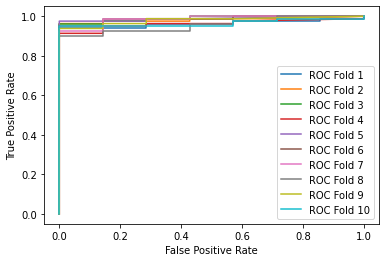

In [24]:
for i in range(len(valid_roc_list)):
    plt.plot(valid_roc_list[i][0],       # fpr
             valid_roc_list[i][1],       # tpr
             label = f'ROC Fold {i+1}')  # label
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [25]:
best_c, best_l1, max_auc, valid_auc = ([], [], [], [])

for i in range(len(valid_roc_list)):
    best_c.append(clf_list[i].C_)
    best_l1.append(clf_list[i].l1_ratio_)
    max_auc.append(clf_list[i].scores_[1].mean(axis=0).max())
    valid_auc.append(valid_auc_list[i])

results = pd.DataFrame({"c": best_c,
                        "l1": best_l1,
                        "max_aux": max_auc,
                        "valid_auc": valid_auc})

In [26]:
print(results, "\n")
print(f'Max AUC on Validity Set: {np.mean(max_auc)}')
print(f'AUC on Validity Set: {np.mean(valid_auc)}')

                        c   l1   max_aux  valid_auc
0  [0.046415888336127774]  [0]  0.981739   0.962963
1  [0.005994842503189409]  [0]  0.978662   0.982363
2  [0.005994842503189409]  [0]  0.979356   0.989418
3  [0.046415888336127774]  [0]  0.986253   0.962081
4  [0.005994842503189409]  [0]  0.977983   0.987654
5  [0.005994842503189409]  [0]  0.978472   0.987654
6  [0.005994842503189409]  [0]  0.976515   0.985891
7  [0.000774263682681127]  [0]  0.983460   0.955908
8    [0.3593813663804626]  [0]  0.983475   0.979718
9  [0.046415888336127774]  [0]  0.983996   0.964727 

Max AUC on Validity Set: 0.9809911616161617
AUC on Validity Set: 0.9758377425044091


In [27]:
# let's retrain the model on the complete training set

clf.fit(train_data, train_target)

print('Training C: ', clf.C_)
print('Training l1_ratio: ', clf.l1_ratio_)
print('Training Max auc_roc:', clf.scores_[1].mean(axis=0).max())

Training C:  [0.04641589]
Training l1_ratio:  [0]
Training Max auc_roc: 0.9839962121212122
